In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=30,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rotation_range=30,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        )
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255)
    train_mask_data_gen = ImageDataGenerator()


# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255)
valid_mask_data_gen = ImageDataGenerator()
test_img_data_gen = ImageDataGenerator(rescale=1./255)
test_mask_data_gen = ImageDataGenerator()

In [4]:
dataset_dir = os.path.join(cwd,'SegmentationDataset')

bs = 16

img_h = 256
img_w = 256

num_classes = 3

training_dir = os.path.join(dataset_dir,'training')

train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir,'images'),
                                                      target_size=(img_h,img_w),
                                                      batch_size=bs,
                                                      class_mode=None,#no class subfolder
                                                      shuffle=True,
                                                      interpolation='bilinear',
                                                      seed=SEED)
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir,'masks'),
                                                      target_size=(img_h,img_w),
                                                      batch_size=bs,
                                                      class_mode=None,#no class subfolder
                                                      shuffle=True,
                                                      interpolation='bilinear',
                                                      seed=SEED) #same SEED for same transformation


train_gen=zip(train_img_gen,train_mask_gen)

validation_dir = os.path.join(dataset_dir,'validation')

valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir,'images'),
                                                      target_size=(img_h,img_w),
                                                      batch_size=bs,
                                                      class_mode=None,#no class subfolder
                                                      shuffle=True,
                                                      interpolation='bilinear',
                                                      seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir,'masks'),
                                                      target_size=(img_h,img_w),
                                                      batch_size=bs,
                                                      class_mode=None,#no class subfolder
                                                      shuffle=True,
                                                      interpolation='bilinear',
                                                      seed=SEED) #same SEED for same transformation


valid_gen=zip(valid_img_gen,valid_mask_gen)


Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [5]:
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w,3]))

#mask: 256*256*3 -> [0,0,0]:bg, [255,255,255]:fg -> 256*256*1 -> 0:bg, 1:fg
def prepare_target(x_,y_):
    return x_, tf.where(tf.reduce_any(y_ > 0, axis=-1,keepdims=True),1,0)

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w,3]))

valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()


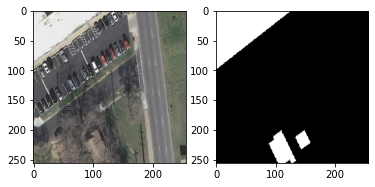

In [16]:
import time
import matplotlib.pyplot as plt

colors_dict = {}
colors_dict[1] = [255, 255, 255]
colors_dict[0] = [0, 0, 0]

iterator = iter(train_dataset)

fig, ax = plt.subplots(1, 2)
augmented_img, target = next(iterator)
augmented_img = augmented_img[0] #first element
augmented_img = augmented_img * 255 #denormalize

target = np.array(target[0, ..., 0])

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [22]:
model = tf.keras.Sequential()

#Encoder
start_f = 8

for i in range(5):
    
    if i==0:
        input_shape = [256, 256, 3]
    else:
        input_shape = [None]
    
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3, 3),
                                    strides=(1, 1),
                                    padding='same',
                                    input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    start_f *= 2
    
model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3, 3),
                                    strides=(1, 1),
                                    padding='same',
                                    input_shape=input_shape))
model.add(tf.keras.layers.ReLU())


start_f = start_f // 2
#Decoder

for i in range(5):
    model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3, 3),
                                    strides=(1, 1),
                                    padding='same',
                                    input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2
    
#Classification layer 1 x 1 x C_i

model.add(tf.keras.layers.Conv2D(filters=1, #num_classes
                                kernel_size=(1, 1),
                                strides=(1, 1),
                                padding='same',
                                activation='sigmoid')) #softmax with many classes



In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
re_lu_23 (ReLU)              (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)       

In [24]:
loss = tf.keras.losses.BinaryCrossentropy()

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def IoU(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred) #tot num of pixel in intersection
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    return (intersection + 1e-7)/ (union + 1e-7)

metrics = ['accuracy', IoU]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    

In [25]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'binary_classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [26]:
model.fit(x=train_dataset,
         epochs=100,
         steps_per_epoch=len(train_img_gen),
         validation_data=valid_dataset,
         validation_steps=len(valid_img_gen),
         callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 56s 2s/step - loss: 0.6589 - accuracy: 0.6645 - IoU: 0.0129 - val_loss: 0.6684 - val_accuracy: 0.6962 - val_IoU: 4.2564e-13
Epoch 2/100
32/32 [==============================] - 38s 1s/step - loss: 0.6397 - accuracy: 0.6830 - IoU: 3.4282e-13 - val_loss: 0.6149 - val_accuracy: 0.6962 - val_IoU: 4.4373e-13
Epoch 3/100
32/32 [==============================] - 37s 1s/step - loss: 0.6256 - accuracy: 0.6751 - IoU: 3.2131e-13 - val_loss: 0.6360 - val_accuracy: 0.6962 - val_IoU: 5.0066e-13
Epoch 4/100
32/32 [==============================] - 40s 1s/step - loss: 0.6186 - accuracy: 0.6730 - IoU: 3.2471e-13 - val_loss: 0.5818 - val_accuracy: 0.6962 - val_IoU: 5.4009e-13
Epoch 5/100
32/32 [==============================] - 40s 1s/step - loss: 0.5800 - accuracy: 0.6843 - IoU: 3.5233e-13 - val_loss: 0.5572 - val_accuracy: 0.6962 - val_IoU: 4.9226e-13
Epoch 6/100
32/32 [==============================] - 40s 1s/step - loss: 0.5754 - accuracy: 0.6859 